## Analyze nonsense mutation rates in intrahost variants

**Note: Start at 2 to replicate from filtered intrahost variants**

1. First aggregate variants:
    - aggregate all samples
    - filter for samples with low mean coverage, lots of reads trimmed, or high percent of N's
    - aggregate SNVs for filtered samples
2. Analyze SNVs.




In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats as st
from Bio import SeqIO
import seaborn as sns

In [22]:
os.chdir('/Users/cwagner2/Work/projects/covid/long-deletions')

In [23]:
## Matplot lib settings
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize']= 12
mpl.rcParams['legend.fontsize']=10
mpl.rcParams['legend.title_fontsize']=12

### 1. Aggregate SNVs:

In [24]:
def aggregate_summary(runs):
    '''
    Aggregates sequencing summary for all samples.
    '''
    data = [] 
    for run in runs:
        with open('intrahost/'+run+'_subnames.csv','r') as f:
            samples = pd.read_csv(f)
        sampleSet = set([item.split('_')[0] for item in os.listdir('intrahost/'+run)])
        missingFile = set(samples['cid'])-sampleSet
        noGisaid = sampleSet - set(samples['cid'])
        if len(noGisaid)|len(missingFile):
            print(f'{run} missing!')
            if len(noGisaid):
                print(f'Not in GISAID: {noGisaid}')
            else:
                print(f'File not present {missingFile}')
            
        for i,sample in zip(samples.index,samples.cid.values):
            if sample not in missingFile:
                with open('intrahost/'+run+'/'+sample+'_summary.csv','r') as f:
                    df = pd.read_csv(f)
                    df['gisaid_id'] = samples.at[i,'gisaid_full_name']
                    df['run'] = run
                    data.append(df)
        for sample in noGisaid:
            with open('intrahost/'+run+'/'+sample+'_summary.csv','r') as f:
                    df = pd.read_csv(f)
                    df['gisaid_id'] = pd.NA
                    df['run'] = run
                    data.append(df)
    agg = pd.concat(data).reset_index(drop=True)
    return agg

def plot_hist(data,variable,cutoff,output=None):
    fig,ax = plt.subplots()
    ax.hist(data[variable],bins=50,ec='white')
    ax.set_xlabel(variable)
    ax.set_ylabel('Number of samples')
    ax.axvline(cutoff,ls='dashed',lw=2,color='k')
    if output:
        fig.savefig(output,bbox_inches='tight',dpi=300)
        
def filt_qc(data,c1,c2,c3):
    filt = data[(data.Percent_Trimmed< c1) & (data.Mean_Coverage>c2) & (data.Percent_N<c3)][['run','Sample_Name','gisaid_id']].copy()
    return filt.reset_index(drop=True)

def aggregate_snv(df):
    data = []
    for i in df.index:
        run = df.at[i,'run']
        sample = df.at[i,'Sample_Name']
        gisaid_id = df.at[i,'gisaid_id']
        with open('intrahost/'+run+'/'+sample + '_bcftools_variants.csv','r') as f:
            file = pd.read_csv(f)
            file['run'] = run
            file['gisaid_id'] = gisaid_id
            data.append(file)
                
    agg = pd.concat(data).reset_index(drop=True)
    trim = agg.drop(columns='SAMPLE')
    return trim

In [25]:
runs = ['220825_A01152_0262_BHKTFNDRX2','220829_A01152_0263_BHKTNYDRX2','220909_A01152_0269_AHJHWNDRX2','220916_A01152_0272_AHNCVNDRX2']

In [26]:
qc = aggregate_summary(runs)

220916_A01152_0272_AHNCVNDRX2 missing!
File not present {'62PSPJEZJBF6'}


In [27]:
mean_cov = np.mean(qc['Mean_Coverage'])

In [28]:
std_cov= np.std(qc['Mean_Coverage'])

In [29]:
perTrimmed = 25
meanCov = mean_cov-(2*std_cov)
perN = 10
print(meanCov)

7419.4813838479895


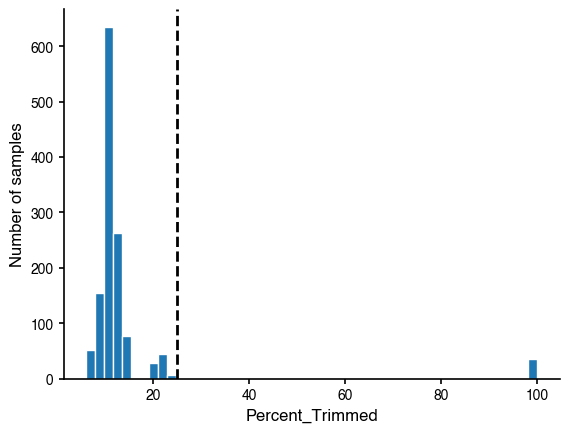

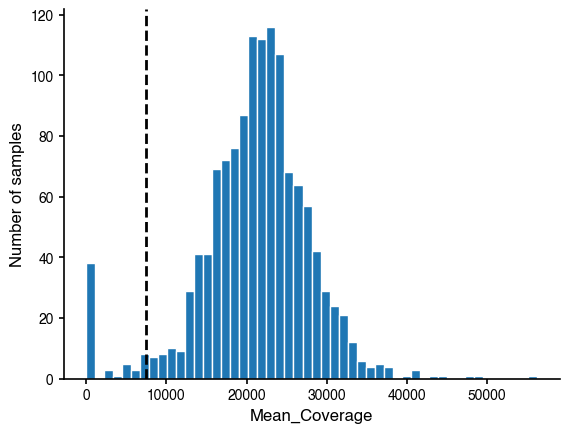

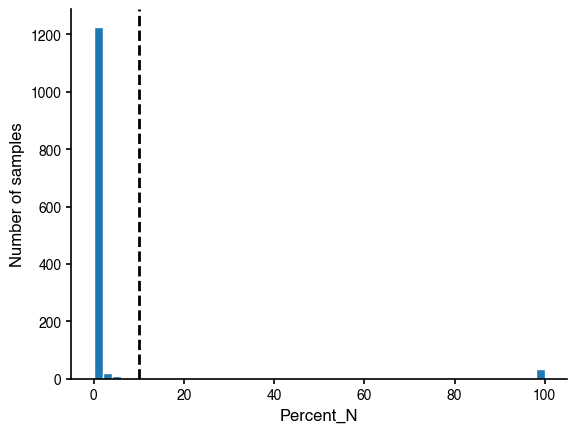

In [30]:
plot_hist(qc,'Percent_Trimmed',perTrimmed,'figs/reviews/ISNVcutoffs_percentTrimmed.pdf')
plot_hist(qc,'Mean_Coverage',meanCov,'figs/reviews/ISNVcutoffs_MeanCov.pdf')
plot_hist(qc,'Percent_N',perN,'figs/reviews/ISNVcutoffs_percentN.pdf')

In [31]:
clean = filt_qc(qc,perTrimmed,meanCov,perN)

In [32]:
print(len(qc)-len(clean))

55


Filtered out 55 samples due to not passing QC

In [33]:
variants = aggregate_snv(clean)

In [34]:
variants.columns

Index(['gene', 'AAPOS', 'AAREF', 'AASUB', 'TCOV', 'VCOV', 'AAFREQ', 'NTPOS',
       'snpid', 'nsp', 'NSPPOS', 'NSPREF', 'NSPSUB', 'run', 'gisaid_id'],
      dtype='object')

In [115]:
len(variants.gisaid_id.unique())

1245

In [35]:
variants.drop(columns=['run'],inplace=True)
variants.to_csv('intrahost/intrahost_variants.tsv',sep='\t',index=False)

### 2. Analyze variants

In [42]:
with open('intrahost/intrahost_variants.tsv','r') as f:
    variants = pd.read_csv(f,sep='\t')

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_38200/1685023392.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  variants = pd.read_csv(f,sep='\t')


In [43]:
variants

,gene,AAPOS,AAREF,AASUB,TCOV,VCOV,AAFREQ,NTPOS,snpid,nsp,NSPPOS,NSPREF,NSPSUB,gisaid_id
0,ORF1a_polyprotein,135,S,R,31419,31411,0.999745,670,T670G,leader_protein,135.0,S,R,hCoV-19/USA/TX-CDC-UW22081608152/2022
1,ORF1a_polyprotein,672,K,N,11025,11025,1.000000,2281,G2281T,nsp2,492.0,K,N,hCoV-19/USA/TX-CDC-UW22081608152/2022
2,ORF1a_polyprotein,842,T,I,21152,21151,0.999953,2790,C2790T,nsp3,24.0,T,I,hCoV-19/USA/TX-CDC-UW22081608152/2022
3,ORF1a_polyprotein,1307,G,S,12369,12367,0.999838,4184,G4184A,nsp3,489.0,G,S,hCoV-19/USA/TX-CDC-UW22081608152/2022
4,ORF1a_polyprotein,1405,K,T,66,1,0.015152,4479,A4479C,nsp3,587.0,K,T,hCoV-19/USA/TX-CDC-UW22081608152/2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142033,nucleocapsid_phosphoprotein,203,R,K,10943,10937,0.999452,28881,G28881A,-,NaN,NaN,NaN,hCoV-19/USA/WA-UW-22090590294/2022
142034,nucleocapsid_phosphoprotein,204,G,R,11123,11123,1.000000,28883,G28883C,-,NaN,NaN,NaN,hCoV-19/USA/WA-UW-22090590294/2022
142035,nucleocapsid_phosphoprotein,377,D,Y,10216,10215,0.999902,29402,G29402T,-,NaN,NaN,NaN,hCoV-19/USA/WA-UW-22090590294/2022
142036,nucleocapsid_phosphoprotein,413,S,R,8412,8409,0.999643,29510,A29510C,-,NaN,NaN,NaN,hCoV-19/USA/WA-UW-22090590294/2022


In [44]:
variants.gene.unique()

array(['ORF1a_polyprotein', 'ORF1ab_polyprotein_ribosomal_slippage',
       'surface_glycoprotein', 'ORF3a_protein', 'envelope_protein',
       'membrane_glycoprotein', 'ORF8_protein',
       'nucleocapsid_phosphoprotein', 'ORF10_protein', 'ORF7b',
       'ORF7a_protein', 'ORF6_protein'], dtype=object)

In [45]:
geneMapping = {'ORF1a_polyprotein':'ORF1a', 
               'ORF1ab_polyprotein_ribosomal_slippage':'ORF1b',
               'surface_glycoprotein':'S', 
               'ORF3a_protein':'ORF3a', 
               'envelope_protein':'E',
               'membrane_glycoprotein':'M', 
               'ORF8_protein':'ORF8',
               'nucleocapsid_phosphoprotein':'N',
               'ORF10_protein':'ORF10',
               'ORF7b':'ORF7b',
               'ORF7a_protein':'ORF7a',
               'ORF6_protein':'ORF6'
              } ## This has ORF10 but not ORF9B. I think that's okay.
variants['Gene'] = variants.gene.map(geneMapping)

First, let's remove any samples with major variant having a stop mutation in any gene.

In [46]:
majorStop = variants[(variants.AASUB=='X') & (variants.AAFREQ>0.5)]

In [47]:
print(len(majorStop))
majorStopID = majorStop.gisaid_id.unique()
print(len(majorStopID))
majorStop.groupby(['Gene'])['AASUB'].count()

242
230


Gene
N        216
ORF10      1
ORF1a      1
ORF7a      8
ORF7b      1
ORF8      13
S          2
Name: AASUB, dtype: int64

In [48]:
print(majorStop[majorStop.Gene=='N'].AAPOS.unique())
majorStop[majorStop.Gene=='N']

['30' '31' 30 31]


,gene,AAPOS,AAREF,AASUB,TCOV,VCOV,AAFREQ,NTPOS,snpid,nsp,NSPPOS,NSPREF,NSPSUB,gisaid_id,Gene
182,nucleocapsid_phosphoprotein,30,G,X,43,41,0.953488,28361,G28361T,-,NaN,NaN,NaN,hCoV-19/USA/WA-CDC-UW22081615781/2022,N
580,nucleocapsid_phosphoprotein,30,G,X,84,70,0.833333,28361,G28361T,-,NaN,NaN,NaN,hCoV-19/USA/WA-CDC-UW22081658894/2022,N
928,nucleocapsid_phosphoprotein,30,G,X,55,52,0.945455,28361,G28361T,-,NaN,NaN,NaN,hCoV-19/USA/WA-CDC-UW22081631274/2022,N
1052,nucleocapsid_phosphoprotein,30,G,X,38,36,0.947368,28361,G28361T,-,NaN,NaN,NaN,hCoV-19/USA/WA-CDC-UW22081696653/2022,N
1154,nucleocapsid_phosphoprotein,30,G,X,30,29,0.966667,28361,G28361T,-,NaN,NaN,NaN,hCoV-19/USA/WA-CDC-UW22081653997/2022,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138447,nucleocapsid_phosphoprotein,30,G,X,71,65,0.915493,28361,G28361T,-,NaN,NaN,NaN,hCoV-19/USA/WA-UW-22082404301/2022,N
139076,nucleocapsid_phosphoprotein,30,G,X,71,62,0.873239,28361,G28361T,-,NaN,NaN,NaN,hCoV-19/USA/WA-UW-22082645046/2022,N
139672,nucleocapsid_phosphoprotein,30,G,X,26,22,0.846154,28361,G28361T,-,NaN,NaN,NaN,hCoV-19/USA/WA-UW-22082716696/2022,N
139955,nucleocapsid_phosphoprotein,30,G,X,91,87,0.956044,28361,G28361T,-,NaN,NaN,NaN,hCoV-19/USA/WA-UW-22082923235/2022,N


N site 30 & 31 seem to be a frequent site of a small amino acid deletion (2-4 amino acids) in Omicron variants: https://nextstrain.org/ncov/gisaid/global/all-time?c=gt-N_29,30,31,32,33,34&gmax=29533&gmin=28274

These stop codons may be miscalled deletions.

In [49]:
noMajorStop = variants[~variants.gisaid_id.isin(majorStopID)]

Let's apply some frequency filter cutoffs. We're require total coverage at a site to be 100, the variant to have a coverge of 10, and for it to be a minor variant.

In [50]:
filt = noMajorStop[(noMajorStop.TCOV>100) & (noMajorStop.VCOV>10) & (noMajorStop.AAFREQ < 0.5)]

In [51]:
len(filt.gisaid_id.unique())

1015

In [52]:
len(filt)

29210

In [53]:
def gene_lengths(ref):
    genes = []
    lengths = []
    order = []
    count = 0
    ref = SeqIO.read(ref,'gb')
    for feature in ref.features:
            if feature.type == "CDS":
                name = feature.qualifiers['gene'][0]
                start = feature.location.start
                end = feature.location.end
                length = len(ref.seq[start:end].translate(to_stop=True))
                genes.append(name)
                lengths.append(length)
                order.append(count)
                count+=1
    df = pd.DataFrame({'Gene':genes,'protein_length':lengths,'order':order})
    return df

def plot_number_intrahostStops(df):
    fig,ax = plt.subplots(ncols=2,tight_layout=True,figsize=(8,4))
    ax[0].bar(x=df['Gene'],height=df['n'])
    ax[0].set_xticks(ax[0].get_xticks(), labels=df['Gene'],rotation=90)
    ax[0].set_ylabel('Number of intra-host premature stops')
    ax[1].bar(x=df['Gene'],height=df['norm'])
    ax[1].set_xticks(ax[1].get_xticks(), labels=df['Gene'],rotation=90)
    ax[1].set_ylabel('Rate of intra-host premature stops\nper codon per sample')

In [54]:
geneLengths = gene_lengths('params/sars2_ref.gb')

In [55]:
geneLengths

,Gene,protein_length,order
0,ORF1a,4401,0
1,ORF1b,2695,1
2,S,1273,2
3,ORF3a,275,3
4,E,75,4
5,M,222,5
6,ORF6,61,6
7,ORF7a,121,7
8,ORF7b,43,8
9,ORF8,121,9


In [56]:
stopCounts = filt[filt.AASUB=='X'].groupby('Gene')['gene'].count().reset_index().rename(columns={'gene':'n'}).merge(geneLengths,how='outer').sort_values(['order'])
stopCounts['norm'] = stopCounts['n']/stopCounts['protein_length']/len(filt.gisaid_id.unique())

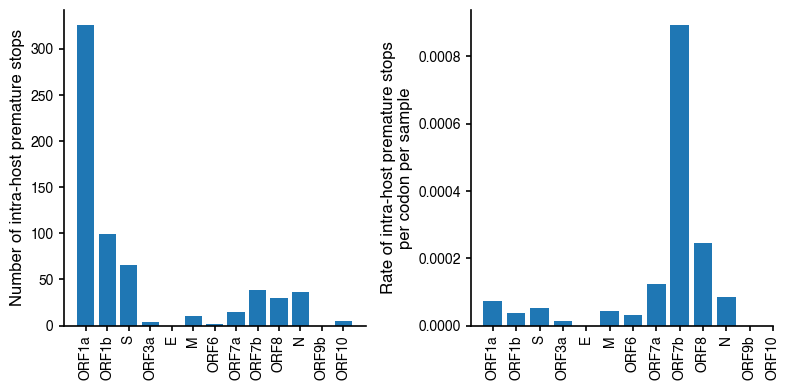

In [57]:
plot_number_intrahostStops(stopCounts)

In [58]:
stops = filt[filt.AASUB=='X'].merge(geneLengths,how='outer').sort_values(['order'])
stops = stops[stops.Gene!='ORF9b']
stops['perFreq'] = stops['AAFREQ']*100

In [59]:
len(stops)

633

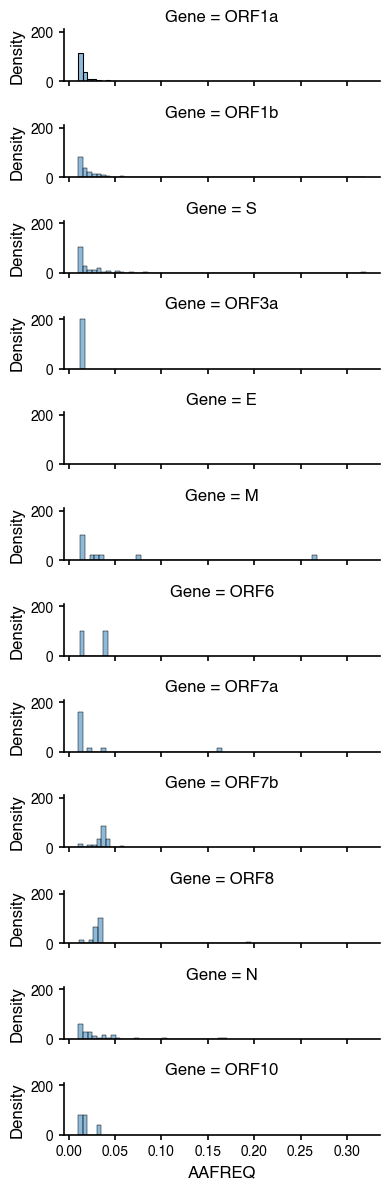

In [60]:

g = sns.FacetGrid(stops, row="Gene",height=1,aspect=4)

g.map_dataframe(sns.histplot, x="AAFREQ",hue="Gene",common_norm=False,common_bins=True,stat='density',binwidth=0.005)


/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cwagner2/miniconda3/envs/orf8ko/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


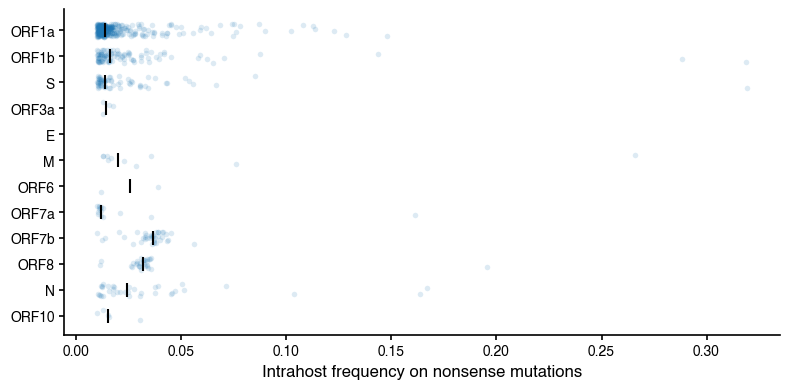

In [61]:
fig, ax = plt.subplots(tight_layout=True,figsize=(8,4))
medians = [np.median(stops[stops.Gene==gene]['AAFREQ']) for gene in stopCounts['Gene']]
sns.stripplot(data=stops, y='Gene',x='AAFREQ',size=4,ax=ax,alpha=0.15,jitter=0.25,zorder=1)
ax.set_xlabel('Intrahost frequency on nonsense mutations')
ax.set_ylabel('')
for loc,median in zip(stopCounts.Gene,medians):
    ax.scatter(x=median,y=loc,c='k',zorder=2,marker='|',s=100)

In [62]:

## Matplot lib settings
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.titlesize']= 12
mpl.rcParams['legend.fontsize']=10
mpl.rcParams['legend.title_fontsize']=12

In [63]:
def plot_figure(dfA,dfB,path=None):
    fig = plt.figure(layout='constrained', figsize=(7,6))
    subfigs = fig.subfigures(2, 1, wspace=0.07,height_ratios=[0.9,1])
    axTop = subfigs[0].subplots(1, 2)
    axTop[0].bar(x=dfA['Gene'],height=dfA['n'])
    axTop[0].set_xticks(axTop[0].get_xticks(), labels=dfA['Gene'],rotation=90)
    axTop[0].set_ylabel('Number of intra-host\nnonsense mutations')
    axTop[1].bar(x=dfA['Gene'],height=dfA['norm'])
    axTop[1].set_xticks(axTop[1].get_xticks(), labels=dfA['Gene'],rotation=90)
    axTop[1].set_ylabel('Rate of intra-host\nnonsense mutations\nper codon per sample')
    
    axBottom = subfigs[1].subplots(1,1)
    medians = [np.median(dfB[dfB.Gene==gene]['AAFREQ']) for gene in dfB['Gene'].unique()]
    sns.stripplot(data=dfB, y='Gene',x='AAFREQ',size=4,ax=axBottom,alpha=0.15,jitter=0.25,zorder=1)
    axBottom.set_xlabel('Intrahost frequency of nonsense mutations')
    axBottom.set_ylabel('')
    for loc,median in zip(dfB.Gene.unique(),medians):
        axBottom.scatter(x=median,y=loc,c='k',zorder=2,marker='|',s=100)
        print(median)
        
        
    axTop[0].text(x=-4.2,y=325,s='A',fontdict={'fontsize': 18,'fontweight' : 'black','horizontalalignment':'left'})
    axTop[1].text(x=-6.1,y=0.0009, s='B',fontdict={'fontsize': 18,'fontweight' : 'black','horizontalalignment':'left'})
    axBottom.text(x=-0.05,y=-0.1, s='C',fontdict={'fontsize': 18,'fontweight' : 'black','horizontalalignment':'left'})
    if path:
        fig.savefig(path,dpi=300,bbox_inches='tight')

In [64]:
np.median(stops[(stops.Gene!='ORF8') & (stops.Gene!='ORF7b')& (stops.Gene!='E')]['perFreq'])

1.48191

In [65]:
stops

,gene,AAPOS,AAREF,AASUB,TCOV,VCOV,AAFREQ,NTPOS,snpid,nsp,NSPPOS,NSPREF,NSPSUB,gisaid_id,Gene,protein_length,order,perFreq
0,ORF1a_polyprotein,1465,Y,X,16977.0,507.0,0.029864,4660.0,T4660G,nsp3,647.0,Y,X,hCoV-19/USA/WA-CDC-UW22081612354/2022,ORF1a,4401.0,0.0,2.986393
221,ORF1a_polyprotein,3561,R,X,20890.0,246.0,0.011776,10946.0,A10946T,3C-like_proteinase,298.0,R,X,hCoV-19/USA/WA-UW-22082114686/2022,ORF1a,4401.0,0.0,1.177597
220,ORF1a_polyprotein,2904,E,X,3912.0,95.0,0.024284,8975.0,G8975T,nsp4,141.0,E,X,hCoV-19/USA/WA-UW-22082114686/2022,ORF1a,4401.0,0.0,2.428425
219,ORF1a_polyprotein,2524,L,X,16501.0,170.0,0.010302,7836.0,T7836A,nsp3,1706.0,L,X,hCoV-19/USA/WA-UW-22082114686/2022,ORF1a,4401.0,0.0,1.030241
218,ORF1a_polyprotein,2239,C,X,5342.0,55.0,0.010296,6982.0,C6982A,nsp3,1421.0,C,X,hCoV-19/USA/WA-UW-22082919021/2022,ORF1a,4401.0,0.0,1.029577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,ORF10_protein,29,Q,X,8247.0,127.0,0.015400,29642.0,C29642T,-,NaN,NaN,NaN,hCoV-19/USA/WA-UW-22080895315/2022,ORF10,NaN,NaN,1.539954
616,ORF10_protein,29,Q,X,496.0,15.0,0.030242,29642.0,C29642T,-,NaN,NaN,NaN,hCoV-19/USA/WA-UW-22082238905/2022,ORF10,NaN,NaN,3.024194
617,ORF10_protein,29,Q,X,6691.0,87.0,0.013003,29642.0,C29642T,-,NaN,NaN,NaN,hCoV-19/USA/WA-UW-22082275119/2022,ORF10,NaN,NaN,1.300254
618,ORF10_protein,29,Q,X,7477.0,119.0,0.015915,29642.0,C29642T,-,NaN,NaN,NaN,hCoV-19/USA/WA-CDC-UW22090648040/2022,ORF10,NaN,NaN,1.591547


In [66]:
stopCounts

,Gene,n,protein_length,order,norm
3,ORF1a,326.0,4401.0,0.0,0.000073
4,ORF1b,99.0,2695.0,1.0,0.000036
10,S,66.0,1273.0,2.0,0.000051
5,ORF3a,4.0,275.0,3.0,0.000014
11,E,NaN,75.0,4.0,NaN
0,M,10.0,222.0,5.0,0.000044
6,ORF6,2.0,61.0,6.0,0.000032
7,ORF7a,15.0,121.0,7.0,0.000122
8,ORF7b,39.0,43.0,8.0,0.000894
9,ORF8,30.0,121.0,9.0,0.000244


0.01400255307740245
0.0161751
0.01403395182176175
0.01417696968357415
nan
0.0197730169907308
0.0255794581242603
0.0117309
0.0364162
0.031903799999999996
0.02411524130387695


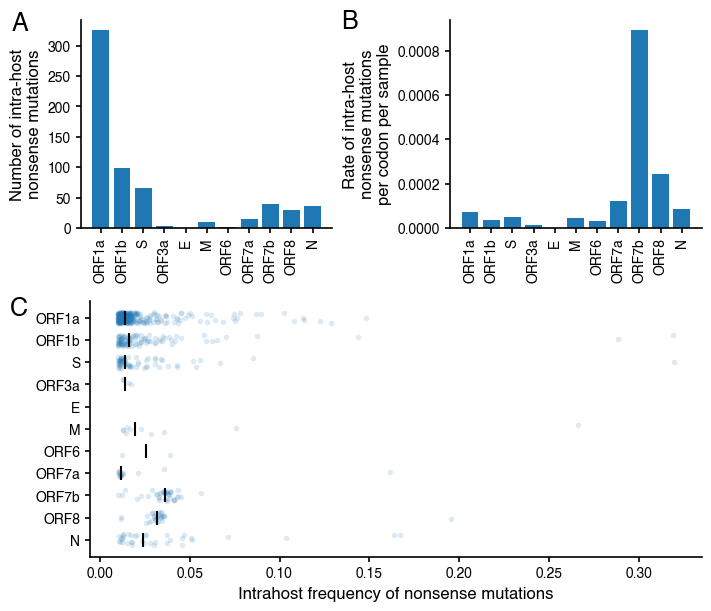

In [69]:
plot_figure(stopCounts[(stopCounts.Gene!='ORF9b')&(stopCounts.Gene!='ORF10')],stops[stops.Gene!='ORF10'])

0.01400255307740245
0.0161751
0.01403395182176175
0.01417696968357415
nan
0.0197730169907308
0.0255794581242603
0.0117309
0.0364162
0.031903799999999996
0.02411524130387695


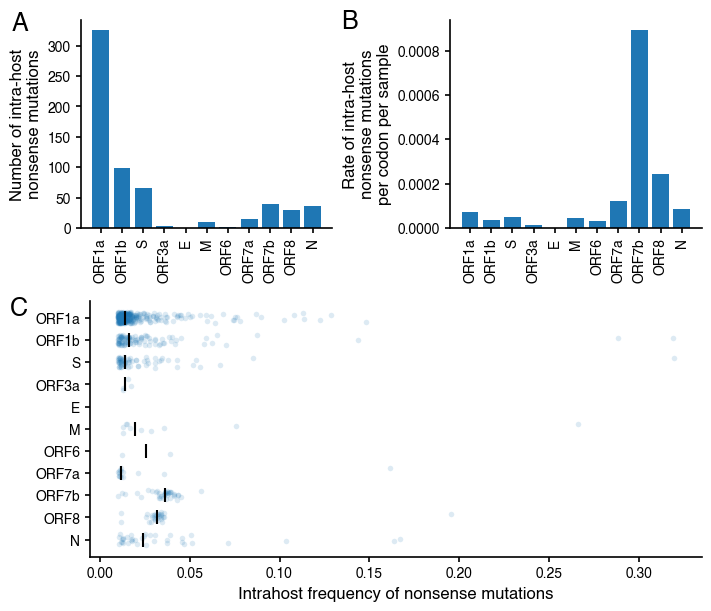

In [71]:
plot_figure(stopCounts[(stopCounts.Gene!='ORF9b')&(stopCounts.Gene!='ORF10')],stops[stops.Gene!='ORF10'])

In [72]:
import matplotlib.ticker as mtick


def plot_figureNew(dfA,dfB,path=None):
    fig, ax = plt.subplots(ncols=2,layout='constrained', figsize=(7,3),sharey=True)
    ax[0].barh(y=dfA['Gene'],width=dfA['norm'],facecolor='#71717B',edgecolor='k')
    ax[0].set_yticks(ax[0].get_yticks(), labels=dfA['Gene'])
    ax[0].set_ylabel('')
    ax[0].set_xlabel('Rate of intra-host nonsense\nmutations per codon per sample')
    
    medians = [np.median(dfB[dfB.Gene==gene]['perFreq']) for gene in dfB['Gene'].unique()]
    sns.stripplot(data=dfB, y='Gene',x='perFreq',size=4,ax=ax[1],alpha=0.2,jitter=0.25,zorder=1,facecolor='#71717B',edgecolor='k')
    ax[1].set_xlabel('Intrahost frequency of\nnonsense mutations')
    ax[1].set_ylabel('')

    for loc,median in zip(dfB.Gene.unique(),medians):
        ax[1].scatter(x=median,y=loc,c='k',zorder=2,marker='|',s=100)
        
        
    ax[0].text(x=-0.00026,y=0,s='A',fontdict={'fontsize': 18,'fontweight' : 'black','horizontalalignment':'left'})
    ax[1].text(x=-5.6,y=0, s='B',fontdict={'fontsize': 18,'fontweight' : 'black','horizontalalignment':'left'})
    ax[1].set_xlim(0,20)
    ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    ax[1].yaxis.set_tick_params(labelbottom=True)
    #ax[1].axvline(x=1.5,ls='dashed',color='k')
    if path:
        fig.savefig(path,dpi=300,bbox_inches='tight')

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_38200/1791962297.py:27: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.savefig(path,dpi=300,bbox_inches='tight')
/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_38200/1791962297.py:27: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.savefig(path,dpi=300,bbox_inches='tight')


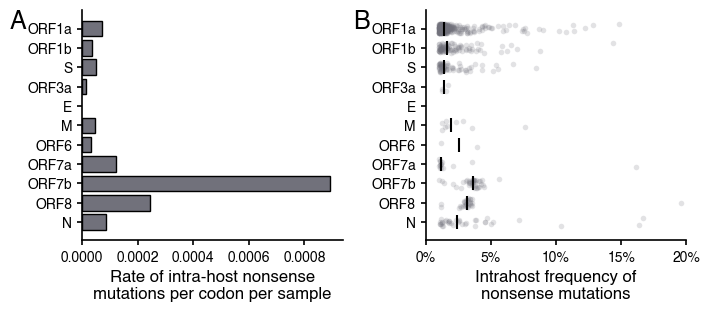

In [73]:
plot_figureNew(stopCounts[(stopCounts.Gene!='ORF9b')&(stopCounts.Gene!='ORF10')],stops[stops.Gene!='ORF10'],'figs/fig3/intrahost.pdf')

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_38200/1791962297.py:27: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.savefig(path,dpi=300,bbox_inches='tight')
/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_38200/1791962297.py:27: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.savefig(path,dpi=300,bbox_inches='tight')


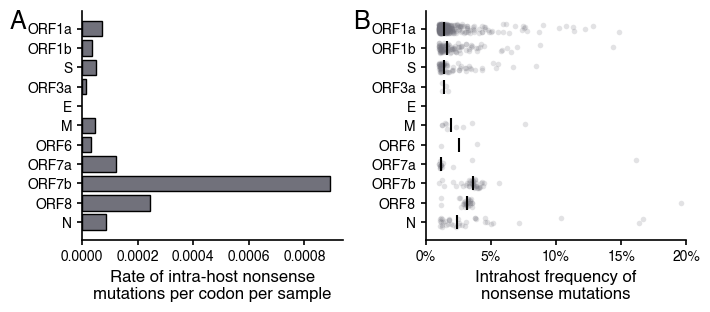

In [74]:
plot_figureNew(stopCounts[(stopCounts.Gene!='ORF9b')&(stopCounts.Gene!='ORF10')],stops[stops.Gene!='ORF10'],'figs/fig3/intrahost.jpg')

In [75]:
st.f_oneway(stops[stops.Gene=='ORF1a']['AAFREQ'],stops[stops.Gene=='ORF1b']['AAFREQ'],stops[stops.Gene=='S']['AAFREQ'],stops[stops.Gene=='ORF3a']['AAFREQ'],stops[stops.Gene=='ORF7a']['AAFREQ'],stops[stops.Gene=='ORF6']['AAFREQ'])

F_onewayResult(statistic=1.250420051012732, pvalue=0.28427877979802013)

In [76]:
st.mannwhitneyu(stops[stops.Gene=='M']['AAFREQ'],stops[stops.Gene=='N']['AAFREQ'])

MannwhitneyuResult(statistic=178.0, pvalue=0.9681355613021834)

In [77]:
st.mannwhitneyu(stops[stops.Gene=='ORF7b']['AAFREQ'],stops[stops.Gene=='ORF8']['AAFREQ'])

MannwhitneyuResult(statistic=867.0, pvalue=0.0006557748435849792)

In [78]:
st.mannwhitneyu(stops[stops.Gene=='ORF7b']['AAFREQ'],stops[(stops.Gene!='ORF7b')&(stops.Gene!='ORF8')&(stops.Gene!='E')]['AAFREQ'])

MannwhitneyuResult(statistic=17872.0, pvalue=5.299662837362697e-11)

In [79]:
st.mannwhitneyu(stops[stops.Gene=='ORF8']['AAFREQ'],stops[(stops.Gene!='ORF7b')&(stops.Gene!='ORF8')&(stops.Gene!='E')]['AAFREQ'])

MannwhitneyuResult(statistic=13463.0, pvalue=4.077954413597984e-08)